# RIWI Sport

### conexion and data

In [133]:
# Create the connection to PostgreSQL database
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
import os

load_dotenv()

# Leer variables de entorno
db_user = os.getenv("DB_USER")
db_pass = os.getenv("DB_PASS")
db_host = os.getenv("DB_HOST")
db_port = os.getenv("DB_PORT")
db_name = os.getenv("DB_NAME")

try:
    connection_string = f"postgresql+psycopg2://{db_user}:{db_pass}@{db_host}:{db_port}/{db_name}"
    engine = create_engine(connection_string)
    print("Sucesfully connected to PostgreSQL")
except Exception as e:
    print(f"error in the database connection: {e}")



Sucesfully connected to PostgreSQL


In [134]:
# verify connection by executing a simple query
if engine:
    try: 
        query_check="SELECT count(*) FROM access;"
        df = pd.read_sql((query_check), engine)
        count = df.iloc[0,0]
        print(f"Number of records in the table access: {count}")
    except Exception as e:
        print(f"No records found in the orders table: {e}")

Number of records in the table access: 6


### Query

In [135]:
# Load data into DataFrame
sql_query = """SELECT
    cus.id_customer AS customer_id,
    cus.email AS customer_email,
    cus.phone AS customer_phone,
    o.id_order,
    o.total AS order_total,
    o.payment_date,
    o.order_status_id,
    od.id_order_item,
    od.amount AS item_quantity,
    od.price AS item_price,
    od.subtotal AS item_subtotal,
    p.id_product,
    p.name AS product_name,
    p.price AS product_price,
    p.stock,
    c.id_category,
    c.name AS category_name
FROM
    "order" o
JOIN 
    customer cus ON o.customer_id = cus.id_customer
JOIN 
    order_item od ON o.id_order = od.order_id
JOIN
    product p ON od.product_id = p.id_product
JOIN
    category c ON p.category_id = c.id_category
ORDER BY
    o.id_order, od.id_order_item
"""
if engine:
    try:
        df_riwi = pd.read_sql(sql_query, engine)
        print("df_riwi:", len(df_riwi), "records loaded.")
    
    except Exception as e:
        print(f" error to load the dataframe: {e}")
        df_riwi = pd.DataFrame()

df_riwi: 1496 records loaded.


In [136]:
# Basic cleaning and type verification
if not df_riwi.empty:
    print("\n --- DataFrame Info ---")
    df_riwi.info()
    print("\n--- Missing Values per Column ---")
    print(df_riwi.isnull().sum()) 
    num_duplicados = df_riwi.duplicated().sum()
    print(f"Duplicate data before clean {num_duplicados}")
    print("Successfully cleaning duplicate data...")
    df_riwi.drop_duplicates(inplace=True)
    print("\n cleaning complete.")


 --- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1496 entries, 0 to 1495
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   customer_id      1496 non-null   int64              
 1   customer_email   1496 non-null   object             
 2   customer_phone   1496 non-null   object             
 3   id_order         1496 non-null   int64              
 4   order_total      1496 non-null   float64            
 5   payment_date     1496 non-null   datetime64[ns, UTC]
 6   order_status_id  1496 non-null   int64              
 7   id_order_item    1496 non-null   int64              
 8   item_quantity    1496 non-null   int64              
 9   item_price       1496 non-null   float64            
 10  item_subtotal    1496 non-null   float64            
 11  id_product       1496 non-null   int64              
 12  product_name     1496 non-null   object            

In [137]:
# Create sales table
if not df_riwi.empty:
    df_ventas = df_riwi[[
        'id_order',
        'payment_date',
        'order_total',
        'id_order_item',
        'item_quantity',
        'item_price',
        'item_subtotal',
        'id_product',
        'product_name',
        'product_price',
        'id_category',
        'category_name'
    ]].copy()

    # order the DataFrame by payment_date descending, id_order ascending, id_order_item ascending
    df_ventas = df_ventas.sort_values(['payment_date', 'id_order', 'id_order_item'], ascending=[False, True, True])

    # Show basic info about the sales table
    print("Created sale table", len(df_ventas), "records.")
    display(df_ventas.head())
    print("\n--- Sales DataFrame Info ---")
    display(df_ventas.info())

Created sale table 1496 records.


,id_order,payment_date,order_total,id_order_item,item_quantity,item_price,item_subtotal,id_product,product_name,product_price,id_category,category_name
151,51,2024-12-28 00:00:00+00:00,687.0,152,1,458.0,458.0,576,Tenis Under Armour Pro 576 8aypc,340.0,5,Fitness
152,51,2024-12-28 00:00:00+00:00,687.0,153,1,279.0,279.0,362,Pelota Head Modern 362 0233b,234.0,7,Natación
153,51,2024-12-28 00:00:00+00:00,687.0,154,2,179.0,358.0,27,Pantalón Under Armour Sport 27 d2r8d,79.0,4,Running
553,180,2024-12-28 00:00:00+00:00,874.0,554,1,317.0,317.0,971,Camiseta Wilson Modern 971 kjrwg,373.0,7,Natación
1145,387,2024-12-25 00:00:00+00:00,879.0,1146,2,245.0,490.0,938,Pantalón Head Premium 938 i4gbc,386.0,7,Natación



--- Sales DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
Index: 1496 entries, 151 to 1088
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   id_order       1496 non-null   int64              
 1   payment_date   1496 non-null   datetime64[ns, UTC]
 2   order_total    1496 non-null   float64            
 3   id_order_item  1496 non-null   int64              
 4   item_quantity  1496 non-null   int64              
 5   item_price     1496 non-null   float64            
 6   item_subtotal  1496 non-null   float64            
 7   id_product     1496 non-null   int64              
 8   product_name   1496 non-null   object             
 9   product_price  1496 non-null   float64            
 10  id_category    1496 non-null   int64              
 11  category_name  1496 non-null   object             
dtypes: datetime64[ns, UTC](1), float64(4), int64(5), object(2)
memory usage: 151.

None

In [138]:
# Get aggregated sales data by city, category, product, and customer when applicable
if not df_riwi.empty:
    # aggregated by category
    agregados_categoria = df_riwi.groupby('category_name').agg({
        'item_quantity': 'sum',
        'item_subtotal': 'sum'
    }).reset_index().rename(columns={
        'item_quantity': 'total_quantity',
        'item_subtotal': 'total_sales'
    })

    print("\n--- Aggregated by category ---")
    display(agregados_categoria)

    # Aggregated by product
    agregados_producto = df_riwi.groupby('product_name').agg({
        'item_quantity': 'sum',
        'item_subtotal': 'sum'
    }).reset_index().rename(columns={
        'item_quantity': 'total_quantity',
        'item_subtotal': 'total_sales'
    })

    print("\n--- Aggregated by product ---")
    display(agregados_producto)

    # Aggregated by customer
    agregados_cliente = df_riwi.groupby('customer_id').agg({
        'item_quantity': 'sum',
        'item_subtotal': 'sum'
    }).reset_index().rename(columns={
        'item_quantity': 'total_quantity',
        'item_subtotal': 'total_sales'
    })

    print("\n--- Aggregated by customer ---")
    display(agregados_cliente)


--- Aggregated by category ---


,category_name,total_quantity,total_sales
0,Accesorios,444,113500.0
1,Baloncesto,463,125623.0
2,Fitness,412,106451.0
3,Fútbol,425,109016.0
4,Natación,391,105556.0
5,Running,374,103644.0
6,Tenis,497,132212.0



--- Aggregated by product ---


,product_name,total_quantity,total_sales
0,Balón Adidas Classic 72 p54yn,2,82.0
1,Balón Adidas Classic 724 tw9ye,7,759.0
2,Balón Adidas Competition 571 qb1l0,3,870.0
3,Balón Adidas Premium 276 0p85x,3,1308.0
4,Balón Adidas Pro 402 ikwyc,8,1401.0
...,...,...,...
769,Tenis Wilson Premium 128 ze26n,3,308.0
770,Tenis Wilson Pro 895 2p1lk,1,23.0
771,Tenis Wilson Professional 149 0dnv3,2,810.0
772,Tenis Wilson Sport 931 k8p06,5,990.0



--- Aggregated by customer ---


,customer_id,total_quantity,total_sales
0,1,63,19694.0
1,2,57,14577.0
2,3,42,12494.0
3,4,68,15318.0
4,5,30,7737.0
5,6,92,22848.0
6,7,75,15628.0
7,8,55,16527.0
8,9,86,26208.0
9,10,91,27868.0


###  KPI's

In [139]:
# Central tendency: mean, median, mode of spending (per order/customer).
if not df_riwi.empty:
    gastos_por_pedido = df_riwi.groupby('id_order')['order_total'].sum()

    media_gasto = gastos_por_pedido.mean()
    mediana_gasto = gastos_por_pedido.median()
    moda_gasto = gastos_por_pedido.mode().iloc[0]

    print("\n--- Central tendency of sale per order ---")
    print(f"Mean: {media_gasto:.2f}")
    print(f"Median: {mediana_gasto:.2f}")
    print(f"Mode: {moda_gasto:.2f}")


--- Central tendency of sale per order ---
Mean: 1677.88
Median: 1389.50
Mode: 705.00


In [140]:
# Dispersion: variance, standard deviation; optional: IQR (interquartile range).
if not df_riwi.empty:
    varianza_gasto = gastos_por_pedido.var()
    desviacion_estandar_gasto = gastos_por_pedido.std()
    iqr_gasto = gastos_por_pedido.quantile(0.75) - gastos_por_pedido.quantile(0.25)

    print("\n--- Dispersion ---")
    print(f"Variance of sales per order: {varianza_gasto:.2f}")
    print(f"Standar desviation of sales per order {desviacion_estandar_gasto:.2f}")
    print(f"IQR (interquartile range): {iqr_gasto:.2f}")


--- Dispersion ---
Variance of sales per order: 1555016.72
Standar desviation of sales per order 1247.00
IQR (interquartile range): 1836.25


#### KPIs de negocio:

In [141]:
# Average Order Value (AOV) per order and per customer.
if not df_riwi.empty:
    aov_por_pedido = df_riwi.groupby('id_order')['order_total'].mean()
    aov_por_cliente = df_riwi.groupby('customer_id')['order_total'].mean()

    print("\n--- Average Order Value (AOV) per order ---")
    print(aov_por_pedido.head())

    print("\n--- Average Order Value (AOV) per customer ---")
    print(aov_por_cliente.head())


--- Average Order Value (AOV) per order ---
id_order
1     82.0
2    672.0
3    365.0
4    812.0
5    643.0
Name: order_total, dtype: float64

--- Average Order Value (AOV) per customer ---
customer_id
1    621.483871
2    498.866667
3    750.684211
4    444.485714
5    583.823529
Name: order_total, dtype: float64


In [142]:
# Top 5 categories/products by sales/quantity
if not df_riwi.empty:
    # Top 5 categories per sales
    top_categorias = agregados_categoria.sort_values(by='total_sales', ascending=False).head(5)
    print("\n--- Top 5 categories per sales ---")
    display(top_categorias)

    # Top 5 products by quantity sold
    top_productos_cantidad = agregados_producto.sort_values(by='total_quantity', ascending=False).head(5)
    print("\n--- Top 5 products by quantity sold ---")
    display(top_productos_cantidad)

    # Top 5 products by sales
    top_productos_ingreso = agregados_producto.sort_values(by='total_sales', ascending=False).head(5)
    print("\n--- TTop 5 products by sales ---")
    display(top_productos_ingreso)


--- Top 5 categories per sales ---


,category_name,total_quantity,total_sales
6,Tenis,497,132212.0
1,Baloncesto,463,125623.0
0,Accesorios,444,113500.0
3,Fútbol,425,109016.0
2,Fitness,412,106451.0



--- Top 5 products by quantity sold ---


,product_name,total_quantity,total_sales
566,Raqueta Adidas Professional 443 0w3h6,16,3909.0
440,Pantalón Puma Premium 687 cm0gs,16,4630.0
21,Balón Mizuno Modern 174 whfnj,14,3506.0
641,Shorts Adidas Professional 614 4ag7k,12,2766.0
127,Camiseta Reebok Competition 338 mlft2,12,2766.0



--- TTop 5 products by sales ---


,product_name,total_quantity,total_sales
440,Pantalón Puma Premium 687 cm0gs,16,4630.0
566,Raqueta Adidas Professional 443 0w3h6,16,3909.0
21,Balón Mizuno Modern 174 whfnj,14,3506.0
231,Gorra Spalding Sport 685 kbbsp,9,3480.0
613,Raqueta Spalding Premium 731 323kb,9,3445.0


In [143]:
# Product with highest price variability (standard deviation)
if not df_riwi.empty:
    variabilidad_precios = df_riwi.groupby('product_name')['item_price'].std().reset_index().rename(columns={'item_price': 'price_stddev'})
    producto_mayor_variabilidad = variabilidad_precios.sort_values(by='price_stddev', ascending=False).head(1)

    print("\n--- Product with highest price variability ---")
    display(producto_mayor_variabilidad)


--- Product with highest price variability ---


,product_name,price_stddev
261,Guayos Babolat Premium 695 o7ycr,332.340187


### Visualizations(Matplotlib y Seaborn)

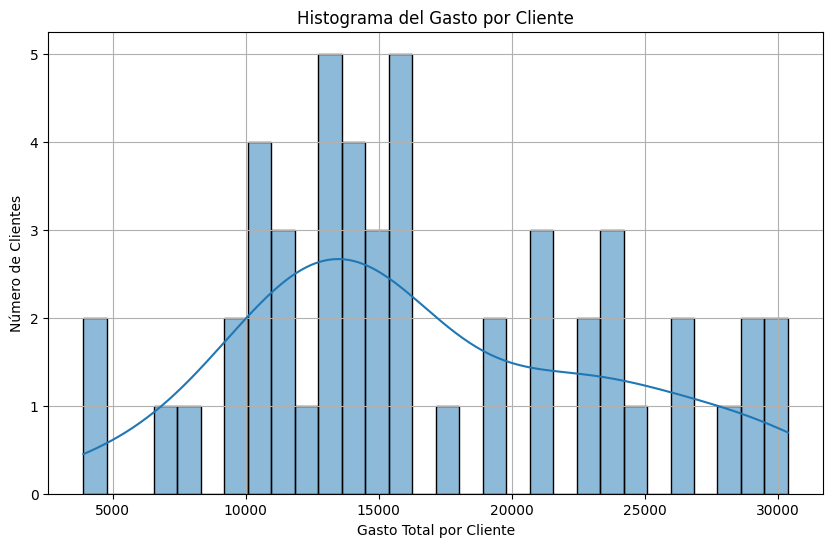

In [144]:
# Histogram of spending per customer
if not df_riwi.empty:
    gastos_por_cliente = df_riwi.groupby('customer_id')['order_total'].sum()

    plt.figure(figsize=(10, 6))
    sns.histplot(gastos_por_cliente, bins=30, kde=True)
    plt.title('Histograma del Gasto por Cliente')
    plt.xlabel('Gasto Total por Cliente')
    plt.ylabel('Número de Clientes')
    plt.grid(True)
    plt.show() 

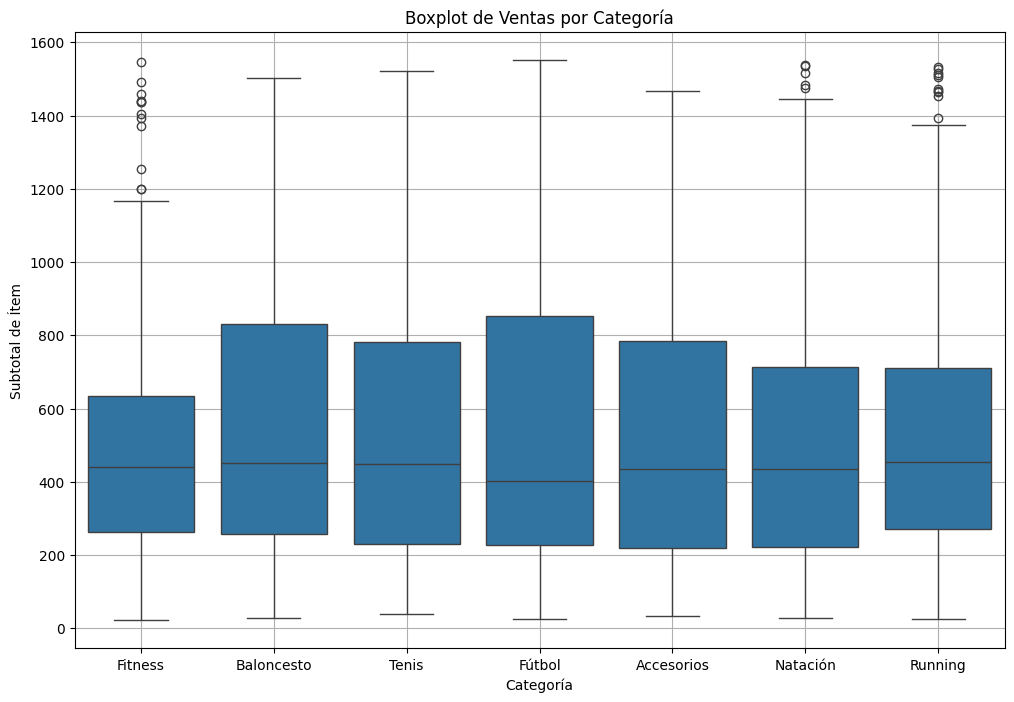

In [145]:
# Boxplot of sales by category (to observe distribution and outliers)
if not df_riwi.empty:
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='category_name', y='item_subtotal', data=df_riwi)
    plt.title('Boxplot de Ventas por Categoría')
    plt.xlabel('Categoría')
    plt.ylabel('Subtotal de Ítem')
    plt.grid(True)
    plt.show()

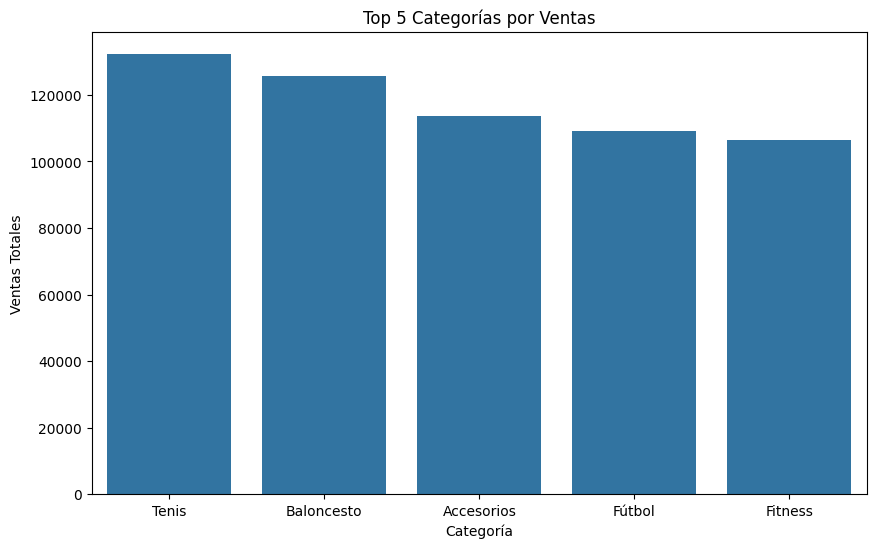

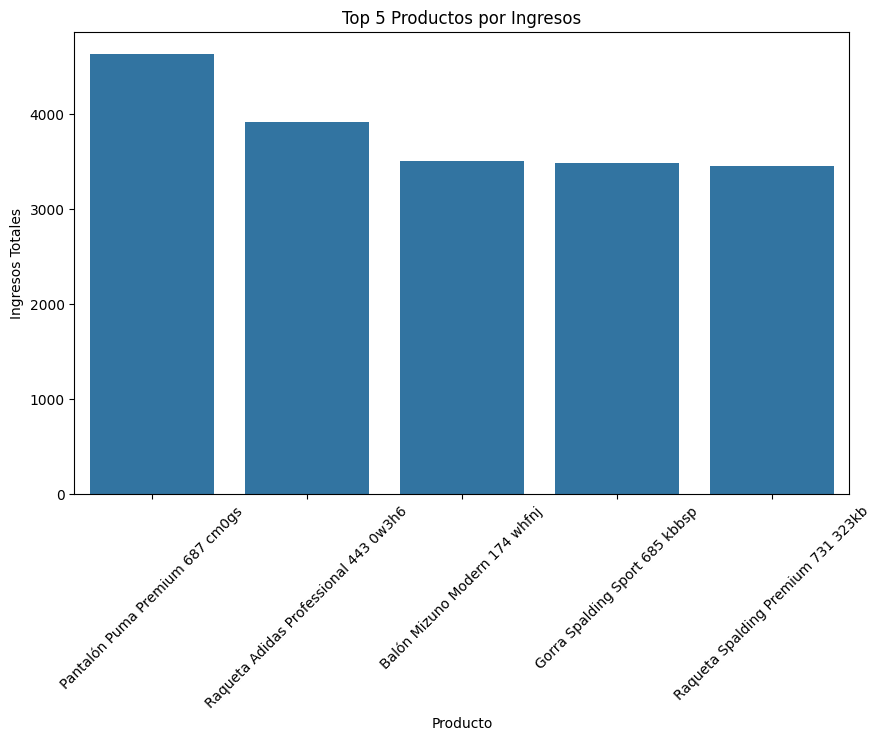

In [147]:
# Bar plots for top categories/products
if not df_riwi.empty:
    # Top 5 categories by sales
    plt.figure(figsize=(10, 6))
    sns.barplot(x='category_name', y='total_sales', data=top_categorias)
    plt.title('Top 5 Categorías por Ventas')
    plt.xlabel('Categoría')
    plt.ylabel('Ventas Totales')
    plt.show()

    # Top 5 products by sales
    plt.figure(figsize=(10, 6))
    sns.barplot(x='product_name', y='total_sales', data=top_productos_ingreso)
    plt.title('Top 5 Productos por Ingresos')
    plt.xlabel('Producto')
    plt.ylabel('Ingresos Totales')
    plt.xticks(rotation=45)
    plt.show() 

### Insight

**Insight**
A partir del análisis de ventas, se observa que la mayoría de los ingresos provienen de pocos clientes y productos específicos. Esto indica que existe una concentración de ventas en ciertos segmentos, mientras que otros clientes y productos tienen baja participación.

**Recomendación:**
Enfoca estrategias de fidelización y promociones en los clientes y productos más activos para potenciar su valor. Además, revisa los segmentos menos participativos para identificar oportunidades de mejora o ajuste en el portafolio.